<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E5%8D%97%E4%BA%9EPA%E5%BB%A0%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90_R6_1219.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
from google.colab import drive
import gc
drive.mount('/content/drive')
gc.collect()
import seaborn as sns
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load data

In [90]:
import pandas as pd
from  tqdm import tqdm_notebook as tqdm

# load
path = '/content/drive/My Drive/南亞PA廠/PA_201605-201909R6.xlsx'
df = pd.read_excel(path,index_col=0,parse_dates = True)

# columns to_numeric
for col in tqdm(df.columns):
  df[col] = pd.to_numeric(df[col],errors='coerce')

# add target
df['target'] =  df['MLPAP_FQ-0619.PV']/df['MLPAP_FQI-0997.PV']

gc.collect()

# show
print(df.shape)
df.tail()


(58081, 72)


,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B04,MLPAP_TI-0706B05,MLPAP_TI-0706B06,MLPAP_TI-0706B07,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,MLPAP_TI-0706B12,MLPAP_TI-0706B13,MLPAP_TI-0706B14,MLPAP_TI-0706B15,MLPAP_TI-0706B16,MLPAP_TI-0706B17,MLPAP_TI-0706B18,MLPAP_TI-0706B19,MLPAP_TI-0706B20,MLPAP_TI-0706B21,MLPAP_TI-0706B22,MLPAP_TI-0706B23,MLPAP_TI-0706B24,MLPAP_TJR-0715A1.PV,MLPAP_TJR-0715A2.PV,MLPAP_TJR-0715B1.PV,MLPAP_TJR-0715B2.PV,MLPAP_TJR-0720A1.PV,MLPAP_TJR-0720A2.PV,MLPAP_TJR-0720B1.PV,MLPAP_TJR-0720B2.PV,MLPAP_TJR-0762A1.PV,MLPAP_TJR-0762A2.PV,MLPAP_TJR-0762B1.PV,MLPAP_TJR-0762B2.PV,MLPAP_TI-0706A02,MLPAP_TI-0706B01,MLPAP_TI-0706C01,MLPAP_TI-0706D01,MLPAP_TI-0716B01,MLPAP_TI-0716C01,MLPAP_TI-0716D01,MLPAP_TI-0716E01,MLPAP_TI-0716A01,MLPAP_TI-0706E01,MLPAP_TI-0706A01,MLPAP_TI-0716D02,MLPAP_TJC-0627.PV,MLPAP_TRC-0610.PV,MLPAP_FR-0632.PV,MLPAP_FQ-0619.PV,MLPAP_TIC-0757A.PV,MLPAP_TI-0757B.PV,MLPAP_PIC-0741.PV,MLPAP_LIC-0738.PV,MLPAP_PIC-0761.PV,MLPAP_TRC-0762.PV,MLPAP_LRC-0729.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_TJR-0721.PV,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755.PV,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
2019-08-31 22:00:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,86.000000,86.0,86.0,86.0,86.0,86.000000,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.251274,82.400002,87.500824,81.800003,0.0,81.048729,83.500000,95.000000,0.0,92.500000,88.900002,87.900002,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,89.000000,85.0,83.0,29.351271,179.899994,0.0,0.0,50.0,0.0,0.3,86.529999,0.3,92.500000,0.0,61.402542,179.000000,65.900002,0.0,58077,4.53,4.523893,3.084818,128.298767,128.125806,-1.0,-50.0,0.008,NaN
2019-08-31 22:30:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,86.991974,86.0,86.0,86.0,86.0,85.008026,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.402390,82.500801,87.500801,81.699997,0.0,81.199997,83.500801,95.297592,0.0,92.548805,88.702408,87.800003,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,89.000000,85.0,83.0,29.299999,179.899994,0.0,0.0,50.0,0.0,0.3,86.400002,0.3,92.500000,0.0,59.948807,180.800003,66.000000,0.0,58078,4.40,4.394068,1.527576,130.698090,130.521894,-1.0,-50.0,0.008,NaN
2019-08-31 23:00:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,86.992149,86.0,86.0,86.0,86.0,85.007851,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.295456,82.500000,87.699211,81.699997,0.0,81.204544,83.500786,95.000786,0.0,92.599998,88.900787,87.800003,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,88.489616,85.0,83.0,29.248865,179.699997,0.0,0.0,50.0,0.0,0.3,86.490005,0.3,92.599998,0.0,60.590916,180.500000,66.099998,0.0,58079,4.57,4.563839,3.129686,129.700394,129.525543,-1.0,-50.0,0.008,NaN
2019-08-31 23:30:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,87.000000,86.0,86.0,86.0,86.0,86.000000,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.248802,82.500000,87.501686,81.800003,0.0,81.199997,83.599998,95.199150,0.0,92.599998,88.999191,87.800003,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,88.000000,85.0,83.0,29.200001,179.600006,0.0,0.0,50.0,0.0,0.3,86.639999,0.3,92.599998,0.0,60.353588,173.600006,66.099998,0.0,58080,4.48,4.473960,3.697329,129.000000,128.826093,-1.0,-50.0,0.008,NaN
2019-09-01 00:00:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,87.000000,86.0,86.0,86.0,86.0,86.000000,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.199997,82.500824,87.699135,81.699997,0.0,81.253754,83.599998,95.100861,0.0,92.651245,88.900002,87.800003,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,88.511322,85.0,83.0,29.200001,179.800003,0.0,0.0,50.0,0.0,0.3,86.570000,0.3,92.699135,0.0,59.848751,180.500000,66.099998,0.0,58081,4.50,4.493933,2.785345,130.401550,130.225754,-1.0,-50.0,0.008,NaN


# 物理上來看這個目標值 合理範圍應該在0~2 

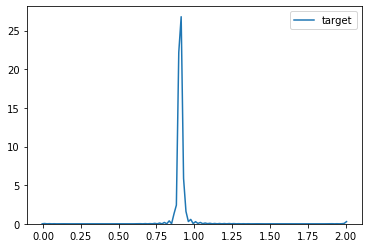

In [91]:
sns.kdeplot(df['target'].clip(0,2))

# 看出來目標值大概落在0.9 這裡進一步將期限縮在0.8~1.0之間來看

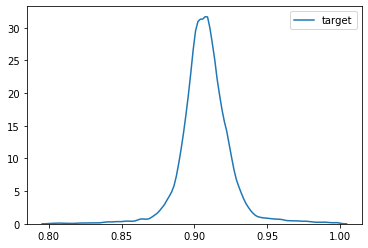

In [92]:
df = df.loc[(df['target']>0.8)&(df['target']<1.0)]
sns.kdeplot(df['target'])

# 根據上面分佈 計算平均值 標準差 lb , ub

lb 0.8550444731989257 ub 0.9603764550555531


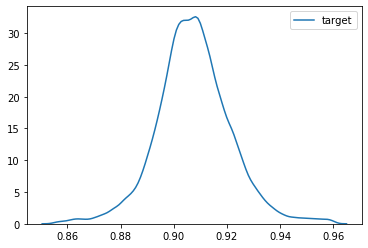

In [93]:
lb = df['target'].mean() - df['target'].std()*3
ub = df['target'].mean() + df['target'].std()*3
print('lb {} ub {}'.format(lb,ub))
df = df.loc[(df['target']>lb)&(df['target']<ub)]
sns.kdeplot(df['target'])

# Load tag盤點表

In [49]:
gc.collect()

0

In [56]:
tag_sheet = pd.read_excel('/content/drive/My Drive/南亞PA廠/tag盤點表_新.xlsx')
chinese_map = dict(zip(tag_sheet['TAG'],tag_sheet['chinese']))
tag_sheet.head()

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
0,1,MLPAP_TJC-0627.PV,OX預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,140,160,***
1,2,MLPAP_TRC-0610.PV,空氣預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,160,200,***
2,3,MLPAP_FR-0632.PV,汽機風量,流量,KNM3/HR,可控制因子,1分鐘2筆,30,90,****
3,4,MLPAP_FQ-0619.PV,OX入料量,流量,kg/HR,可控制因子,1分鐘2筆,2000,8000,****
4,5,MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,溫度,℃,可控制因子,1分鐘2筆,345,365,****


# 定義可控制因子

In [57]:
可控制因子 = tag_sheet[tag_sheet.category=="可控制因子"]['TAG'].values.tolist()
print('可控制因子數量:',len(可控制因子))

可控制因子數量: 13


# 全部欄位線性相關程度

In [60]:
y_name = 'target'
all_corrs = abs(df.corr(method='pearson'))
all_corrs = all_corrs[[y_name]].sort_values(by=y_name,ascending=False)
all_corrs['中文'] = all_corrs.index.map(chinese_map)
all_corrs = all_corrs[['中文',y_name]]
all_corrs.index.name = '英文代號'
all_corrs.head(10).style.background_gradient()

,中文,target
英文代號,,
target,nan,1
MLPAP_LIC-0738.PV,汽鼓(V211)鍋爐水液位,0.359697
MLPAP_TI-0706A01,反應槽觸媒溫度(CL1)_高度(1900),0.305632
MLPAP_FI-V211.PV(轉換後),nan,0.298712
MLPAP_FI-V211.PV,nan,0.298712
MLPAP_TI-0716C01,反應槽觸媒溫度_高度(2715),0.29495
MLPAP_TJR-0721.PV,反應槽出口溫度,0.2941
MLPAP_TI-0706B20,反應槽溫度_多點式(高度 2050),0.292919
MLPAP_TJR-0762A1.PV,鹽浴溫度,0.292678


# 全部欄位非線性相關程度

In [61]:
y_name = 'target'
all_corrs = abs(df.corr(method='spearman'))
all_corrs = all_corrs[[y_name]].sort_values(by=y_name,ascending=False)
all_corrs['中文'] = all_corrs.index.map(chinese_map)
all_corrs = all_corrs[['中文',y_name]]
all_corrs.index.name = '英文代號'
all_corrs.head(10).style.background_gradient()

,中文,target
英文代號,,
target,nan,1
MLPAP_LIC-0738.PV,汽鼓(V211)鍋爐水液位,0.339793
MLPAP_TI-0706A01,反應槽觸媒溫度(CL1)_高度(1900),0.325262
MLPAP_TJR-0721.PV,反應槽出口溫度,0.300901
MLPAP_FI-V211.PV,nan,0.29809
MLPAP_FI-V211.PV(轉換後),nan,0.29809
MLPAP_TRC-0762.PV,鹽浴冷卻器(E112)入口溫度,0.29679
MLPAP_TI-0706B20,反應槽溫度_多點式(高度 2050),0.289943
MLPAP_TI-0716C01,反應槽觸媒溫度_高度(2715),0.286917


# 可控制因子 線性相關程度

In [63]:
y_name = 'target'
可控_corrs = abs(df[可控制因子+[y_name]].corr())
可控_corrs = 可控_corrs[[y_name]].sort_values(by=y_name,ascending=False)
可控_corrs['中文'] = 可控_corrs.index.map(chinese_map)
可控_corrs = 可控_corrs[['中文',y_name]]
可控_corrs.index.name = '英文代號'
可控_corrs.head(10).style.background_gradient()

,中文,target
英文代號,,
target,nan,1
MLPAP_LIC-0738.PV,汽鼓(V211)鍋爐水液位,0.359697
MLPAP_TRC-0762.PV,鹽浴冷卻器(E112)入口溫度,0.253555
MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,0.253197
MLPAP_TJC-0627.PV,OX預熱器出口溫度,0.244805
MLPAP_LRC-0729.PV,鍋爐水液位控制,0.224472
MLPAP_PIC-0741.PV,汽鼓(V211)鍋爐水壓力,0.200097
MLPAP_TIC-0757.PV,反應器A/B側鹽浴溫度差,0.195741
MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,0.171847


# 可控制因子 非線性相關程度

In [64]:
y_name = 'target'
可控_corrs = abs(df[可控制因子+[y_name]].corr(method='spearman'))
可控_corrs = 可控_corrs[[y_name]].sort_values(by=y_name,ascending=False)
可控_corrs['中文'] = 可控_corrs.index.map(chinese_map)
可控_corrs = 可控_corrs[['中文',y_name]]
可控_corrs.index.name = '英文代號'
可控_corrs.head(10).style.background_gradient()

,中文,target
英文代號,,
target,nan,1
MLPAP_LIC-0738.PV,汽鼓(V211)鍋爐水液位,0.339793
MLPAP_TRC-0762.PV,鹽浴冷卻器(E112)入口溫度,0.29679
MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,0.282602
MLPAP_TJC-0627.PV,OX預熱器出口溫度,0.261758
MLPAP_TIC-0757.PV,反應器A/B側鹽浴溫度差,0.209865
MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,0.166474
MLPAP_LRC-0729.PV,鍋爐水液位控制,0.150114
MLPAP_TIC-1721.PV,轉換式冷凝器冷油溫度,0.0841515


# kdeplot

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings;warnings.simplefilter('ignore')

def kdeplot(df,x_col,y_col,y_ub,y_lb,x_range=None):
  hg = df.loc[df[y_col]>y_ub ,x_col]
  lg = df.loc[df[y_col]<y_lb ,x_col]
  sns.kdeplot(hg ,label = y_col + '>' +str(y_ub))
  sns.kdeplot(lg ,label = y_col + '<' +str(y_lb))
  #中文
  try:
    print(pd.Series(x_col).map(chinese_map))
  except:
    pass
  #調整x軸範圍
  if x_range != None:
    plt.xlim(x_range)  
  #秀圖
  plt.legend()   
  plt.xlabel(x_col)
  plt.ylabel('density')
  plt.title(x_col)
  plt.show()

In [67]:
y_ub = df['target'].quantile(0.75)
y_lb = df['target'].quantile(0.25)
print(y_lb,y_ub)

0.9005851230963344 0.9137002341920375


# 全部欄位排名前10 KDEPLOT

In [68]:
all_corrs.head(10).index[1:]

Index(['MLPAP_LIC-0738.PV', 'MLPAP_TI-0706A01', 'MLPAP_TJR-0721.PV',
       'MLPAP_FI-V211.PV', 'MLPAP_FI-V211.PV(轉換後)', 'MLPAP_TRC-0762.PV',
       'MLPAP_TI-0706B20', 'MLPAP_TI-0716C01', 'MLPAP_TI-0716D02'],
      dtype='object', name='英文代號')

0    汽鼓(V211)鍋爐水液位
dtype: object


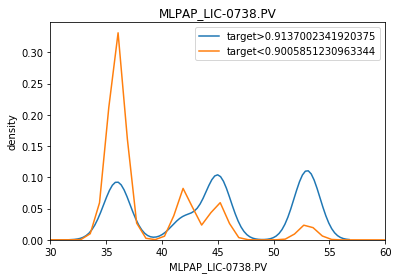

In [70]:
kdeplot(df,'MLPAP_LIC-0738.PV',y_name,y_ub,y_lb,x_range=(30,60))

# 可控制因子 KDEPLOT

In [71]:
可控_corrs.index[1:]

Index(['MLPAP_LIC-0738.PV', 'MLPAP_TRC-0762.PV', 'MLPAP_TIC-0757A.PV',
       'MLPAP_TJC-0627.PV', 'MLPAP_TIC-0757.PV', 'MLPAP_PIC-0761.PV',
       'MLPAP_LRC-0729.PV', 'MLPAP_TIC-1721.PV', 'MLPAP_FR-0632.PV',
       'MLPAP_TRC-0610.PV', 'MLPAP_FQ-0619.PV', 'MLPAP_PIC-0741.PV',
       'MLPAP_TRC-1734.PV'],
      dtype='object', name='英文代號')

0    鹽浴冷卻器(E112)入口溫度
dtype: object


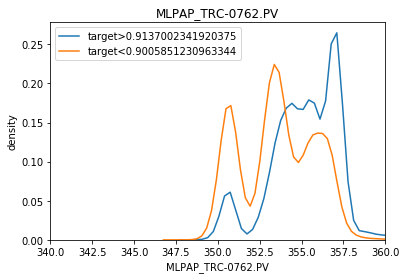

In [73]:
kdeplot(df,'MLPAP_TRC-0762.PV',y_name,y_ub,y_lb,x_range=(340,360))

# correlation matrix

In [75]:
n = 5
t = abs(df[可控制因子+[y_name]].corr())
t = t.sort_values(by='target',ascending=False)
t = t.loc[t.head(n).index,t.head(n).index]
t.style.background_gradient()

,target,MLPAP_LIC-0738.PV,MLPAP_TRC-0762.PV,MLPAP_TIC-0757A.PV,MLPAP_TJC-0627.PV
target,1,0.359697,0.253555,0.253197,0.244805
MLPAP_LIC-0738.PV,0.359697,1,0.320657,0.320812,0.769652
MLPAP_TRC-0762.PV,0.253555,0.320657,1,0.951154,0.462609
MLPAP_TIC-0757A.PV,0.253197,0.320812,0.951154,1,0.408643
MLPAP_TJC-0627.PV,0.244805,0.769652,0.462609,0.408643,1


# features selected

In [76]:
features = 可控制因子.copy()
need_drop_cols = [y_name,'MLPAP_FQI-0997.PV','MLPAP_FQ-0619.PV']
for col_name in need_drop_cols:
  if col_name in features:    
    features.remove(col_name)
    print('移除:',col_name)
print('特徵數量:',len(features))

移除: MLPAP_FQ-0619.PV
特徵數量: 12


# features scaler

In [0]:
from sklearn.preprocessing import StandardScaler
df= df[features+[y_name]]
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [78]:
df.head()

,MLPAP_TJC-0627.PV,MLPAP_TRC-0610.PV,MLPAP_FR-0632.PV,MLPAP_TIC-0757A.PV,MLPAP_PIC-0741.PV,MLPAP_LIC-0738.PV,MLPAP_PIC-0761.PV,MLPAP_TRC-0762.PV,MLPAP_LRC-0729.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_TIC-0757.PV,target
2016-05-10 08:30:00,-1.050220,3.006881,-4.656690,12.379410,NaN,-1.337592,-0.758414,12.453765,0.086952,2.944780,0.159220,-0.968170,0.923057
2016-05-11 14:30:00,-1.067694,0.944341,-1.986141,9.974620,NaN,-0.356853,-0.660790,10.016352,-0.448794,2.744363,-0.230727,-1.080841,0.916474
2016-05-13 17:00:00,-1.040036,0.554778,-0.357513,10.008977,NaN,-1.279551,-0.660790,10.020716,-0.219149,3.064118,0.970369,-0.517485,0.922317
2016-05-17 03:30:00,-1.072257,-0.778442,1.022424,9.665435,NaN,-0.576828,-1.274069,9.837131,-0.739452,2.433029,0.332814,-0.742827,0.896399
2016-05-17 04:00:00,-0.998715,-0.686500,1.073846,9.631079,NaN,-0.453461,-0.711626,9.870002,-0.672221,2.298297,0.454758,-0.855498,0.891030


# replace inf to np.nan and drop nan

In [79]:
import numpy as np
df = df.replace([np.inf,-np.inf],np.nan)
df = df.dropna()
df[y_name].describe()

count    6242.000000
mean        0.912275
std         0.007969
min         0.890203
25%         0.906468
50%         0.913108
75%         0.918759
max         0.925259
Name: target, dtype: float64

# train , test split

In [80]:
from sklearn.model_selection import train_test_split
train ,test = train_test_split(df,test_size=0.2,random_state=42)
print(train.shape)
print(test.shape)

(4993, 13)
(1249, 13)


# Modeling

In [0]:
import lightgbm
from sklearn.svm import SVR
import xgboost
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge,Lasso
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt

In [0]:
def mape_vectorized_v2(a, b):
    a = np.array(a)
    b = np.array(b) 
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [0]:
def metric(yt,yp,name):
  res = pd.DataFrame(index=[name])
  res['R2'] = r2_score(yt,yp)
  res['RMSE'] = sqrt(mean_squared_error(yt,yp))
  res['MAPE'] = mape_vectorized_v2(yt,yp)
  return res

def plot_imp(model):
  imp = pd.DataFrame()
  imp['features'] = features
  imp['中文'] = imp['features'].map(chinese_map)
  imp['imp'] = model.feature_importances_
  return imp.sort_values(by='imp',ascending=False)

def plot_coef(model):
  imp = pd.DataFrame()
  imp['features'] = features
  imp['中文'] = imp['features'].map(chinese_map)
  imp['coef'] = model.coef_
  return imp.sort_values(by='coef',ascending=False)

def plot_pred(yt,yp):
  n = 60
  yt = yt.sort_index().rolling(n).mean()
  yp = yp.sort_index().rolling(n).mean()
  fig = plt.figure(figsize=(10,5))
  plt.plot(yt.index,yt.values,label='y_test',color='blue')
  plt.plot(yp.index,yp.values,label='y_pred',color='red')
  plt.legend()

# Ridge

             R2      RMSE      MAPE
Ridge  0.134462  0.007461  0.006636


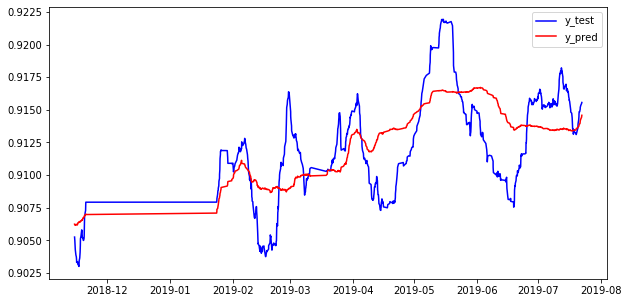

,features,中文,coef
5,MLPAP_LIC-0738.PV,汽鼓(V211)鍋爐水液位,0.013656
3,MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,0.006100
11,MLPAP_TIC-0757.PV,反應器A/B側鹽浴溫度差,0.002540
6,MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,0.001058
8,MLPAP_LRC-0729.PV,鍋爐水液位控制,0.000932


In [84]:
model = Ridge()
model.fit(train[features],train[y_name])
y_pred = model.predict(test[features])
y_pred = pd.Series(y_pred,index=test.index,name='y_pred')
print(metric(test[y_name],y_pred,'Ridge'))
plot_pred(test[y_name],y_pred);plt.show()
plot_coef(model).head(5)

# Lasso

             R2      RMSE      MAPE
Lasso  0.068692  0.007739  0.007054


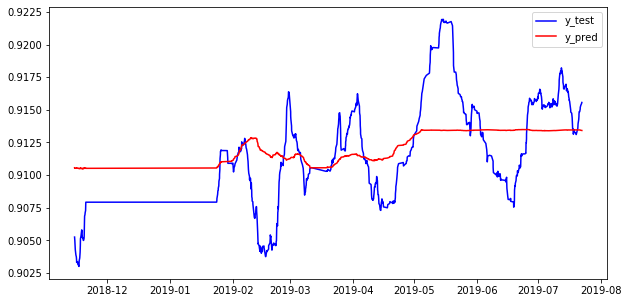

,features,中文,coef
8,MLPAP_LRC-0729.PV,鍋爐水液位控制,0.001022
4,MLPAP_PIC-0741.PV,汽鼓(V211)鍋爐水壓力,0.000228
0,MLPAP_TJC-0627.PV,OX預熱器出口溫度,0.000000
1,MLPAP_TRC-0610.PV,空氣預熱器出口溫度,-0.000000
2,MLPAP_FR-0632.PV,汽機風量,-0.000000


In [85]:
model = Lasso(0.001)
model.fit(train[features],train[y_name])
y_pred = model.predict(test[features])
y_pred = pd.Series(y_pred,index=test.index,name='y_pred')
print(metric(test[y_name],y_pred,'Lasso'))
plot_pred(test[y_name],y_pred);plt.show()
plot_coef(model).head(5)

# xgboost

          R2     RMSE      MAPE
XGB  0.32883  0.00657  0.005523


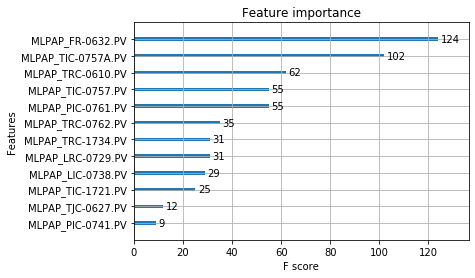

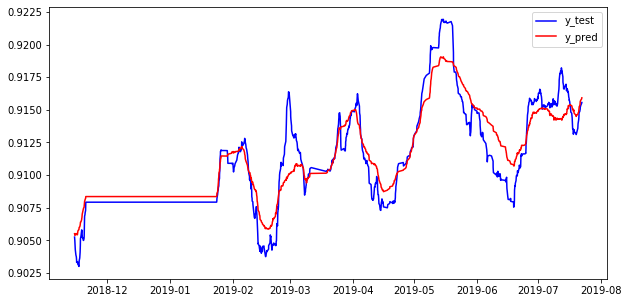

,features,中文,imp
4,MLPAP_PIC-0741.PV,汽鼓(V211)鍋爐水壓力,0.120565
11,MLPAP_TIC-0757.PV,反應器A/B側鹽浴溫度差,0.117950
3,MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,0.113039
6,MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,0.101630
2,MLPAP_FR-0632.PV,汽機風量,0.100887


In [86]:
model = XGBRegressor(objective='reg:squarederror')
model.fit(train[features],train[y_name])
y_pred = model.predict(test[features])
y_pred = pd.Series(y_pred,index=test.index,name='y_pred')
print(metric(test[y_name],y_pred,'XGB'))
xgboost.plot_importance(model);plt.show()
plot_pred(test[y_name],y_pred);plt.show()
plot_imp(model).head(5)

# LGBM

            R2      RMSE      MAPE
LGBM  0.346059  0.006485  0.005302


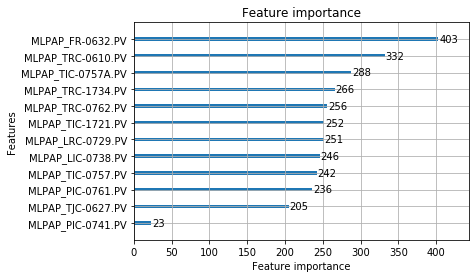

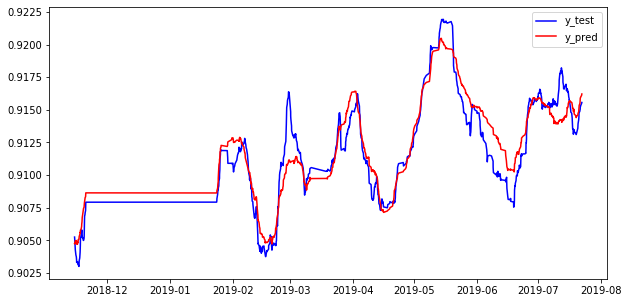

,features,中文,imp
2,MLPAP_FR-0632.PV,汽機風量,403
1,MLPAP_TRC-0610.PV,空氣預熱器出口溫度,332
3,MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,288
10,MLPAP_TRC-1734.PV,轉換式冷凝器熱油溫度,266
7,MLPAP_TRC-0762.PV,鹽浴冷卻器(E112)入口溫度,256


In [87]:
model = LGBMRegressor()
model.fit(train[features],train[y_name])
y_pred = model.predict(test[features])
y_pred = pd.Series(y_pred,index=test.index,name='y_pred')
print(metric(test[y_name],y_pred,'LGBM'))
graph = lightgbm.create_tree_digraph(model)
graph.render(view=True)
lightgbm.plot_importance(model);plt.show()
plot_pred(test[y_name],y_pred);plt.show()
plot_imp(model).head(5)

# SVR

           R2      RMSE      MAPE
SVR -0.267444  0.009029  0.008354


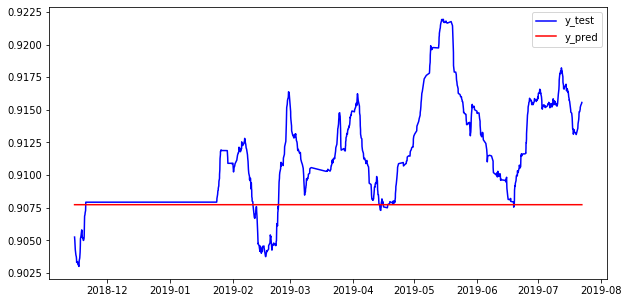

In [88]:
model = SVR()
model.fit(train[features],train[y_name])
y_pred = model.predict(test[features])
y_pred = pd.Series(y_pred,index=test.index,name='y_pred')
print(metric(test[y_name],y_pred,'SVR'))
plot_pred(test[y_name],y_pred)
plt.show()